<a href="https://colab.research.google.com/github/2796gaurav/Hands-OnStockMarketPrediction/blob/main/3_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# install dependencies


!pip install yfinance
!pip install finta

In [18]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime
import numpy as np
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go
from finta import TA

In [73]:
#read time series data 

rel_data = yf.Ticker("RELIANCE.NS") 
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2022,3,19)
data = rel_data.history(start=start, end=end, auto_adjust=True)

data = data.drop(['Dividends','Stock Splits'],axis=1)
data.columns = ["open", "high", "low", "close","volume"]

# data['sma_9'] = TA.SMA(data, 9)


data = data.reset_index()
data = data.sort_values('Date')
data = data[['Date','close']]

#data = data[['Date','close','sma_9','volume']]
data.head()

,Date,close
0,2021-01-01,1981.126831
1,2021-01-04,1984.466064
2,2021-01-05,1959.795410
3,2021-01-06,1908.111694
4,2021-01-07,1905.021729


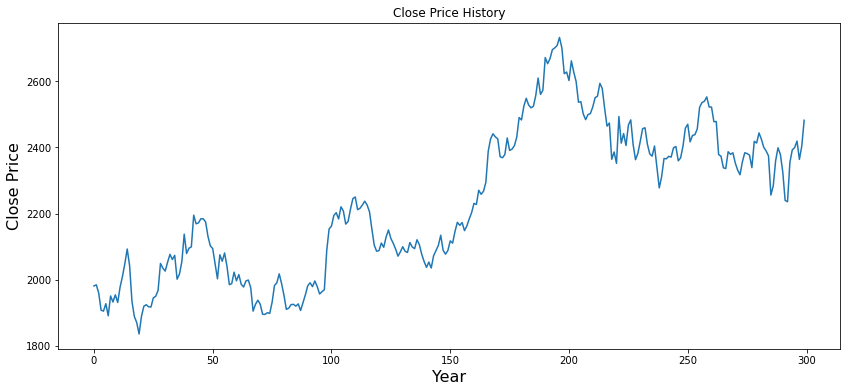

In [74]:
# plot the chart


plt.figure(figsize=(14,6))
plt.title('Close Price History')
plt.plot(data['close'])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Close Price' , fontsize=16)
plt.show()

In [81]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    # X = df[['hour','dayofweek','quarter','month','year',
    #        'dayofyear','dayofmonth','weekofyear','sma_9']]
    if label:
        y = df[label]
        return X, y
    return X

In [82]:
lookback = 50

train_data = data[:-lookback]
test_data = data[-lookback:]

print(train_data.shape)
print(test_data.shape)

(250, 2)
(50, 2)


In [83]:
X_train, y_train = create_features(train_data, label='close')
X_test, y_test = create_features(test_data, label='close')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(250, 8)
(250,)
(50, 8)
(50,)


In [84]:
X_train.tail()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
245,0,2,4,12,2021,363,29,52
246,0,3,4,12,2021,364,30,52
247,0,4,4,12,2021,365,31,52
248,0,0,1,1,2022,3,3,1
249,0,1,1,1,2022,4,4,1


In [85]:
reg = xgb.XGBRegressor(n_estimators=1000)


reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[07:28:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

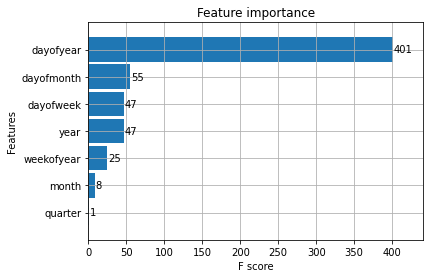

In [86]:
_ = plot_importance(reg, height=0.9)

In [87]:
test_data['pred_Close'] = reg.predict(X_test)

In [88]:
test_data.head()

,Date,close,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,pred_Close
250,2022-01-05,2469.600098,0,2,1,1,2022,5,5,1,2384.80542
251,2022-01-06,2416.500000,0,3,1,1,2022,6,6,1,2384.80542
252,2022-01-07,2436.000000,0,4,1,1,2022,7,7,1,2384.80542
253,2022-01-10,2438.000000,0,0,1,1,2022,10,10,2,2384.80542
254,2022-01-11,2455.550049,0,1,1,1,2022,11,11,2,2384.80542


In [89]:
rmse = mean_squared_error(y_test, test_data['pred_Close'],squared=False)
rmse

81.4383354521529

In [90]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=train_data.Date, y=train_data.close,
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=test_data.Date, y=test_data.close,
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=test_data.Date, y=test_data.pred_Close,
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='black',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='black',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
    ),
    showlegend=True,
    #template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (XGBOOST)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='black'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()